In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix


#### Saving or loading the model as desired.

In [2]:
from tensorflow.keras.models import load_model

In [3]:
#model.save("model_3_0") creates a folder with the same name as the model

In [4]:
#model_2 = load_model("model_2_after_15_epochs") loads a model from this folder

# Table of Contents

[Model 4](#Model-4)

## Model 4

### Importing Data

The following function imports a directory full of subdirectories full of photos, with each subdirectory named after the class of its stored photos.

train_data/ 

     |
     V     
     |
     |
      >  A/ -> A_1, A_2, A_3, etc.
     |
      >  B/ -> B_1, B_2, B_3, etc.
     |  
      >  C/ -> C_1, C_2, C_3, etc.
     |  
      >  D/ -> D_1, D_2, D_3, etc.

In [22]:
def data_generator(image_size, path, preprocess_func=None, split_off_for_val=0.0, split_segment = None):
    this_datagen = ImageDataGenerator(preprocessing_function = preprocess_func, validation_split = split_off_for_val)
    #  note: ImageDataGenerator does not appear to have a parameter for random seeds. Be wary of train/val overlap
    #  note: train/val/test split does not currently work
    this_generator = this_datagen.flow_from_directory(path, 
                                                     target_size=image_size,
                                                     subset = split_segment, #  None|'training'|'validation'
                                                     color_mode='rgb',
                                                     batch_size=80,
                                                     class_mode='categorical',
                                                     shuffle=True)
    return this_generator

As the split functionality did not work, I split the data manually into train/validation/test sets.

3000 images per class became:

900 test + 630 val + 1470 train

87000 images total became:

26100 test + 18270 val + 42630 train

#### Training Data

In [23]:
train_data = data_generator(image_size = [80,80],
                            path = 'data/grassnoted split/asl_alphabet_train',
                           )
train_data


Found 42630 images belonging to 29 classes.


#### Validation Data

In [26]:
validation_data = data_generator(image_size = [80,80], 
                                 path = 'data/grassnoted split/asl_alphabet_validation',
                                )
validation_data


Found 18270 images belonging to 29 classes.


#### Test Data

In [25]:
test_data = data_generator(image_size = [80,80],
                           path = 'data/grassnoted split/asl_alphabet_test',
                          )
test_data


Found 26100 images belonging to 29 classes.


### Creating Model

In [27]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

Importing MobileNetV2 for use in transfer learning.

In [28]:
experienced_model = MobileNetV2(weights='imagenet', include_top=False, input_shape = (80,80,3))
#input shape minimum is 32x32
#this warning is all bark and no bite

Defining an untrained neural network to attach to the end of MobileNetV2 in order to make predictions in our current problem space.

In [29]:
# Assign the output of this base_model to a variable:
base_model_out = experienced_model.output



# Add a pooling layer:
base_model_out = GlobalAveragePooling2D()(base_model_out)

# using a softmabase_model_out activation function:
preds = Dense(29, activation='softmax')(base_model_out)




# Instantiate our final model, where we specify what are the inputs and 
# the outputs will look like
model = Model(inputs = experienced_model.input, 
              outputs = preds)

We can find the number of nodes in the topless MobileNetV2 by looking at the index of the pooling layer. These should be locked in order to preserve their weights.

In [30]:
for i, layer in enumerate(model.layers):
    print(i, layer.name)

0 input_2
1 Conv1
2 bn_Conv1
3 Conv1_relu
4 expanded_conv_depthwise
5 expanded_conv_depthwise_BN
6 expanded_conv_depthwise_relu
7 expanded_conv_project
8 expanded_conv_project_BN
9 block_1_expand
10 block_1_expand_BN
11 block_1_expand_relu
12 block_1_pad
13 block_1_depthwise
14 block_1_depthwise_BN
15 block_1_depthwise_relu
16 block_1_project
17 block_1_project_BN
18 block_2_expand
19 block_2_expand_BN
20 block_2_expand_relu
21 block_2_depthwise
22 block_2_depthwise_BN
23 block_2_depthwise_relu
24 block_2_project
25 block_2_project_BN
26 block_2_add
27 block_3_expand
28 block_3_expand_BN
29 block_3_expand_relu
30 block_3_pad
31 block_3_depthwise
32 block_3_depthwise_BN
33 block_3_depthwise_relu
34 block_3_project
35 block_3_project_BN
36 block_4_expand
37 block_4_expand_BN
38 block_4_expand_relu
39 block_4_depthwise
40 block_4_depthwise_BN
41 block_4_depthwise_relu
42 block_4_project
43 block_4_project_BN
44 block_4_add
45 block_5_expand
46 block_5_expand_BN
47 block_5_expand_relu
48 b

We can see that layer 154 is where our added layers begin. We will lock all layers above 154 and make them untrainable.

In [31]:
for layer in model.layers[:154]:
    layer.trainable=False
    
for layer in model.layers[154:]:
    print(layer.name)
    layer.trainable=True

global_average_pooling2d_1
dense_1


In [32]:
train_data.batch_size

80

In [33]:
step_size_train = train_data.n//train_data.batch_size + 1

# 'train_data.n' = 60,900 images
# 'train_generator.batch_size' = 80 images per batch
# 'step_size_train' = 762  (!needs to be int)
step_size_train

533

### Compiling Model

In [41]:
model.compile(loss = 'categorical_crossentropy', #loss function
                  optimizer = 'Adam',
                  metrics = ['accuracy']) #value to maximize

### Fitting Model

In [39]:
model.fit_generator(train_data, validation_data = validation_data, steps_per_epoch = step_size_train, epochs = 1, verbose = 1)

C:\Users\h\.conda\envs\deeplearningcopy\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


533/533 [==============================] - 202s 379ms/step - loss: 0.7553 - accuracy: 0.7779 - val_loss: 2.3548 - val_accuracy: 0.3888


### Plotting Model Progress

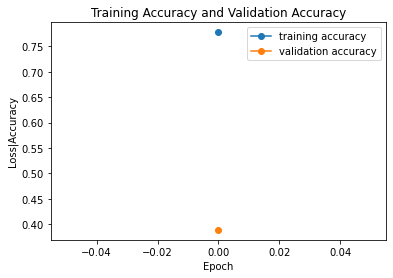

In [42]:
plt.figure()
plt.plot(model.history.history['accuracy'], marker='o', label='training accuracy')
plt.plot(model.history.history['val_accuracy'], marker='o', label='validation accuracy')
plt.title('Training Accuracy and Validation Accuracy')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Loss|Accuracy')
plt.show()